In [1]:
import os
import glob
import cv2

from tqdm import tqdm
import imageio.v3 as imageio


import numpy as np
from numpy.lib.format import open_memmap

加载一张数据集图片查看

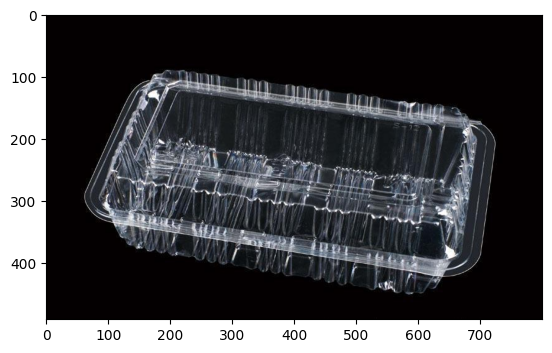

Image shape: (491, 800, 3)


In [2]:
import matplotlib.pyplot as plt
# Load the image
img = imageio.imread("./train/0/img_2.jpg")

# Display the image using matplotlib
plt.imshow(img)
plt.show()

# print the shape of the image
print("Image shape:", img.shape)

图像处理函数，将图像处理成统一大小

In [3]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)
    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)
    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios
    # Ensure dw and dh are positive and can fill to new_shape
    dw = new_shape[1] - new_unpad[0] if dw < 0 else dw
    dh = new_shape[0] - new_unpad[1] if dh < 0 else dh
    dw /= 2  # divide padding into 2 sides
    dh /= 2
    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

图像处理到npy文件，方便训练加载

In [4]:
def load_images_to_npy(folder_path, target_size=(224, 224)):
    """
    读取文件夹下的图片并储存到npy文件中

    Args:
        folder_path: 图片文件夹路径
        output_path: 输出npy文件路径
        target_size: 目标图片尺寸 (width, height)

    Returns:
        images: 图片数组
        filenames: 文件名列表
    """
    # 支持的图片格式
    image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.tiff", "*.webp"]

    # 获取所有图片文件路径
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(folder_path, ext)))
        image_paths.extend(glob.glob(os.path.join(folder_path, ext.upper())))

    images = []
    labels = []

    for img_path in tqdm(image_paths):
        try:
            # 读取图片
            img = imageio.imread(img_path)
            if img is None:
                print(f"无法读取图片: {img_path}")
                continue

            # 图片预处理
            img_processed, _, _ = letterbox(img, new_shape=target_size, auto=False)
            # 归一化
            img_processed = (img_processed/255.0).astype(np.float32)

            images.append(img_processed)
            class_id = int(os.path.basename(os.path.dirname(img_path)))  # 获取文件夹名作为标签
            if class_id in range(6):
                labels.append(0)
            elif class_id in range(6, 14):
                labels.append(1)
            elif class_id in range(14, 37):
                labels.append(2)
            elif class_id in range(27, 40):
                labels.append(3)

        except Exception as e:
            print(f"处理图片 {img_path} 时出错: {e}")

    # 转换为numpy数组
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    return images, labels

In [5]:
def count_jpg_files(folder_path):
    jpg_files = glob.glob(os.path.join(folder_path, "**", "*.jpg"), recursive=True)
    return len(jpg_files)


sets = ["train", "val", "test"]

for set_name in sets:
    num_images = count_jpg_files(f"./{set_name}")
    print(f"找到 {num_images} 张图片")

    if num_images == 0:
        print(f"{set_name} 数据集中没有图片")
        continue

    # 创建内存映射文件
    all_images = open_memmap(f"./{set_name}_images.npy", mode="w+", dtype=np.float32, shape=(num_images, 224, 224, 3))
    all_labels = open_memmap(f"./{set_name}_labels.npy", mode="w+", dtype=np.int32, shape=(num_images,))

    print(f"处理 {set_name} 数据集...")
    current_idx = 0

    for class_id in range(40):
        folder_path = f"./{set_name}/{class_id}"

        images, labels = load_images_to_npy(folder_path, target_size=(224, 224))

        # 写入内存映射文件
        end_idx = current_idx + len(images)
        all_images[current_idx:end_idx] = images
        all_labels[current_idx:end_idx] = labels
        current_idx = end_idx

找到 12984 张图片
处理 train 数据集...


100%|██████████| 385/385 [00:00<00:00, 1200.35it/s]


找到 1418 张图片
处理 val 数据集...


100%|██████████| 42/42 [00:00<00:00, 902.68it/s]


找到 2140 张图片
处理 test 数据集...


100%|██████████| 64/64 [00:00<00:00, 1064.67it/s]


In [6]:
import numpy as np

data = np.load("./train_images.npy",mmap_mode='r')
print(data.shape)

(12984, 224, 224, 3)
